<a href="https://colab.research.google.com/github/CaQtiml/Kaggle_Practice/blob/main/1_FacialKeypoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# from google.colab import files
# files.upload()
# ! mkdir /.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c facial-keypoints-detection
! unzip test
! unzip training


  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 75.0MB/s]
 98% 59.0M/60.1M [00:00<00:00, 72.3MB/s]
100% 60.1M/60.1M [00:00<00:00, 135MB/s] 
 31% 5.00M/16.0M [00:00<00:00, 23.4MB/s]
100% 16.0M/16.0M [00:00<00:00, 53.2MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 120MB/s]
Archive:  test.zip
  inflating: test.csv                
Archive:  training.zip
  inflating: training.csv            


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Flatten, Dense, \
    Dropout, Conv2D,MaxPool2D, ZeroPadding2D, Input, Add, GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [9]:
trainDir = "training.csv"
testDir = "test.csv"
lookIdData = "IdLookupTable.csv"

In [10]:
train_data = pd.read_csv(trainDir)
test_data = pd.read_csv(testDir)

In [ ]:
train_data.head(3).T
# test_data.head(3)

In [12]:
# train_data.isnull().value_counts()
train_data.isnull().any().value_counts()

# There are missing values in 28 columns. 

True     28
False     3
dtype: int64

In [13]:
train_data.fillna(method = 'ffill',inplace = True)
# https://stackoverflow.com/questions/27905295/how-to-replace-nans-by-preceding-or-next-values-in-pandas-dataframe

In [14]:
train_data.isnull().any().value_counts()
# No missing value remain.

False    31
dtype: int64

In [15]:
print(train_data.shape)
print(train_data.columns)

(7049, 31)
Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')


In [16]:
# chk = True
# m = train_data.shape[0]
# for i in range(m):
#     chk = (len(train_data["Image"][0].split(" "))==9216) and chk
# # len(train_data["Image"][0].split(" "))
# print(chk)

In [129]:
images = []
m = train_data.shape[0]
# type(train_data["Image"][0])
for i in range(m):
    img = train_data["Image"][i].split(' ')
    img = [float(x) for x in img]
    images.append(img)


In [130]:
image_list = np.array(images)
image_list = image_list/255.
X = image_list.reshape(-1,96,96,1)

In [131]:
test_data.head(3)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...


In [132]:
testImages = []
for i in range(test_data.shape[0]):
    img = test_data["Image"][i].split(" ")
    img = [float(x) for x in img]
    testImages.append(img)

In [133]:
testImages = np.array(testImages)
testImages = testImages/255.
X_test = testImages.reshape(-1,96,96,1)

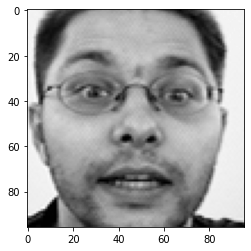

In [134]:
plt.imshow(np.squeeze(X_test[0]),cmap='gray')
plt.show()

In [135]:
training = train_data.drop("Image",axis=1)
y = []
for i in range(training.shape[0]):
    yy = training.iloc[i,:]
    y.append(yy)

y = np.array(y)

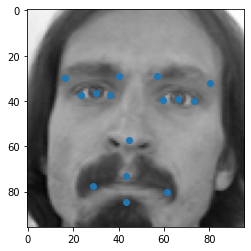

In [136]:
XX = []
yy = []
for i in range(int(y_train.shape[1]/2)):
    XX.append(y[0][i*2])
    yy.append(y[0][i*2+1])
plt.imshow(np.squeeze(X[0]),cmap='gray')
plt.scatter(XX,yy)
plt.show()

In [137]:
X.shape

(7049, 96, 96, 1)

In [138]:
def identity_block(x, f, filters, training=True):
    # print(x.shape)
    x_shortcut = x
    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    # print(x.shape)
    # print("---------------")
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)

    return x


In [139]:
def conv_block(x, f, filters, training=True):
    # print(x.shape)
    x_shortcut = x

    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    x_shortcut =  Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut,training=True)

    # print(x.shape)
    # print("---------------")
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)


    return x


In [140]:
INPUT_SHAPE = (96,96,1)

inputs = Input(INPUT_SHAPE)
x = conv_block(inputs,3,32)
x = identity_block(x,3,32)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = conv_block(x,3,64)
x = identity_block(x,3,64)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = conv_block(x,3,128)
x = identity_block(x,3,128)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = conv_block(x,3,256)
x = identity_block(x,3,256)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(30)(x)



In [141]:
model = tf.keras.Model(inputs, outputs)

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
model.compile(loss=tf.keras.losses.mse, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(), # sgd is short for stochastic gradient descent
              metrics=["mae"])

In [144]:
history = model.fit(X_train,
                    y_train,
                    epochs=15)

Epoch 1/15
177/177 [==============================] - 10s 45ms/step - loss: 123.0744 - mae: 4.7417
Epoch 2/15
177/177 [==============================] - 8s 45ms/step - loss: 8.2432 - mae: 1.8131
Epoch 3/15
177/177 [==============================] - 8s 45ms/step - loss: 7.0494 - mae: 1.6409
Epoch 4/15
177/177 [==============================] - 8s 45ms/step - loss: 6.3108 - mae: 1.5526
Epoch 5/15
177/177 [==============================] - 8s 45ms/step - loss: 5.7236 - mae: 1.4937
Epoch 6/15
177/177 [==============================] - 8s 45ms/step - loss: 5.1803 - mae: 1.4261
Epoch 7/15
177/177 [==============================] - 8s 45ms/step - loss: 4.8171 - mae: 1.3851
Epoch 8/15
177/177 [==============================] - 8s 45ms/step - loss: 4.2654 - mae: 1.3031
Epoch 9/15
177/177 [==============================] - 8s 45ms/step - loss: 3.9716 - mae: 1.2656
Epoch 10/15
177/177 [==============================] - 8s 46ms/step - loss: 3.6367 - mae: 1.1986
Epoch 11/15
177/177 [===============

In [145]:
model.evaluate(X_cv, y_cv)

45/45 [==============================] - 1s 15ms/step - loss: 4.5662 - mae: 1.4108


[4.566198348999023, 1.4107844829559326]

In [146]:
yy_pred = model.predict(X_cv)

In [147]:
# print(yy_pred[0]-yy_test[0])
# print(yy_test[0])

In [ ]:
XX_true = []
YY_true = []
XX_pred = []
YY_pred = []
for j in range(10):
    for i in range(int(yy_pred.shape[1]/2)):
        XX_true.append(y_cv[j][i*2])
        YY_true.append(y_cv[j][i*2+1])
        XX_pred.append(yy_pred[j][i*2])
        YY_pred.append(yy_pred[j][i*2+1])
    plt.imshow(np.squeeze(XX_test[j]),cmap='gray')
    plt.scatter(XX_true,YY_true,color="green")
    plt.scatter(XX_pred,YY_pred,color="red")
    plt.show()

In [ ]:
XX = []
YY = []

y_pred = model.predict(X_test)

for j in range(10):
    for i in range(int(yy_pred.shape[1]/2)):
        XX.append(y_pred[j][i*2])
        YY.append(y_pred[j][i*2+1])
    plt.imshow(np.squeeze(X_test[j]),cmap='gray')
    plt.scatter(XX,YY,color="orange")
    plt.show()

In [150]:
lookid_data = pd.read_csv("IdLookupTable.csv")

In [151]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(y_pred)

In [ ]:
pre_list

In [153]:
rowid = lookid_data['RowId']
rowid=list(rowid)

In [154]:
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

In [155]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [156]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)

In [157]:
submission.to_csv('face_key_detection_submission.csv',index = False)

In [158]:
!kaggle competitions submit -c facial-keypoints-detection -f face_key_detection_submission.csv -m "Test"

100% 629k/629k [00:02<00:00, 241kB/s]
Successfully submitted to Facial Keypoints Detection